In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import time
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [10]:
class PlantDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = [
            f for f in os.listdir(root_dir)
            if f.lower().endswith(('.png','.jpg','.jpeg'))
        ]

        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
        ])
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])  
        img_rgb = Image.open(img_name).convert("RGB")
        img_gray = img_rgb.convert("L")
        real_image = self.transform(img_rgb)
        input_image = self.transform(img_gray)

        return input_image, real_image

Dataset carragado com sucesso
Pasta: ./dataset_treino
Total de imagens encontradas: 50


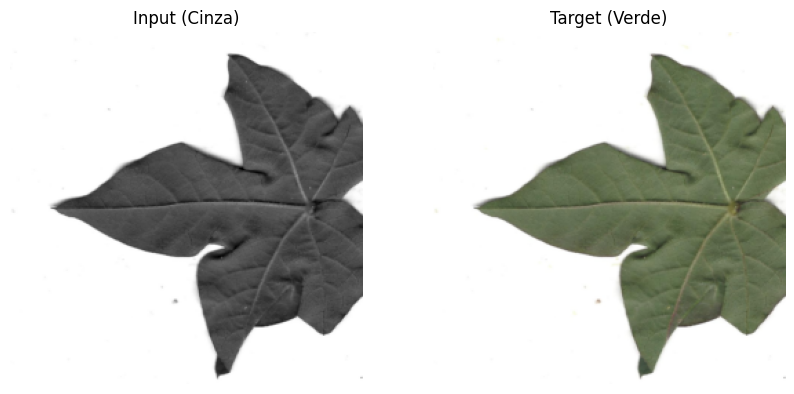

In [12]:
pasta_treino = './dataset_treino'

try:
    dataset = PlantDataset(pasta_treino)

    if len(dataset) == 0:
        print("ERRO AO ENCONTRAR IMAGENS, PASTA VAZIA")

    else:
        print(f"Dataset carragado com sucesso")
        print(f"Pasta: {pasta_treino}")
        print(f"Total de imagens encontradas: {len(dataset)}")

        dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
        gray, color = next(iter(dataloader))

        fig, ax = plt.subplots(1,2, figsize=(10,5))

        ax[0].imshow(gray[0].permute(1, 2, 0).squeeze(), cmap='gray')
        ax[0].set_title("Input (Cinza)")
        ax[0].axis('off')

        ax[1].imshow(color[0].permute(1, 2,0))
        ax[1].set_title("Target (Verde)")
        ax[1].axis('off')

        plt.show()

except FileNotFoundError:
    print("PASTA NÃO ENCONTRADA")

Criação do Discriminador(PatchGAN) e do Gerador(U_Net):

In [13]:
import torch
import torch.nn as nn

# --- O Discriminador (PatchGAN) ---
class PatchGAN(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(PatchGAN, self).__init__()
        
        channels = in_channels + out_channels
        
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# --- O Gerador (U-Net) ---
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def up_block(in_feat, out_feat, dropout=0.0):
            layers = [
                nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1),
                nn.BatchNorm2d(out_feat),
                nn.ReLU(inplace=True)
            ]
            if dropout:
                layers.append(nn.Dropout(dropout))
            return layers

        self.down1 = nn.Sequential(*down_block(in_channels, 64, normalize=False))
        self.down2 = nn.Sequential(*down_block(64, 128))
        self.down3 = nn.Sequential(*down_block(128, 256))
        self.down4 = nn.Sequential(*down_block(256, 512))
        self.down5 = nn.Sequential(*down_block(512, 512))
        self.down6 = nn.Sequential(*down_block(512, 512))
        self.down7 = nn.Sequential(*down_block(512, 512))
        self.down8 = nn.Sequential(*down_block(512, 512, normalize=False))

        self.up1 = nn.Sequential(*up_block(512, 512, dropout=0.5))
        self.up2 = nn.Sequential(*up_block(1024, 512, dropout=0.5))
        self.up3 = nn.Sequential(*up_block(1024, 512, dropout=0.5))
        self.up4 = nn.Sequential(*up_block(1024, 512))
        self.up5 = nn.Sequential(*up_block(1024, 256))
        self.up6 = nn.Sequential(*up_block(512, 128))
        self.up7 = nn.Sequential(*up_block(256, 64))

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        
        return self.final(torch.cat([u7, d1], 1))

Treinamento da rede:

Iniciando treinamento na placa: NVIDIA GeForce RTX 3050 Laptop GPU
Época [10/100] | Loss D (PatchGAN): 0.6450 | Loss G (UNet): 0.0978 | Tempo: 64s


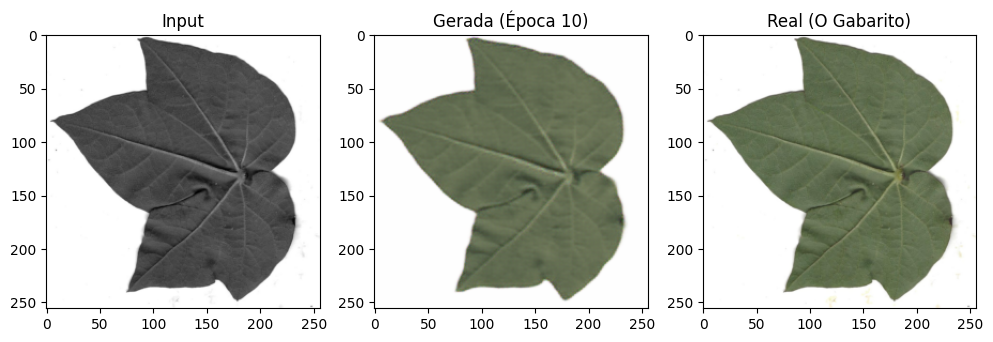

Época [20/100] | Loss D (PatchGAN): 0.6085 | Loss G (UNet): 0.0775 | Tempo: 124s


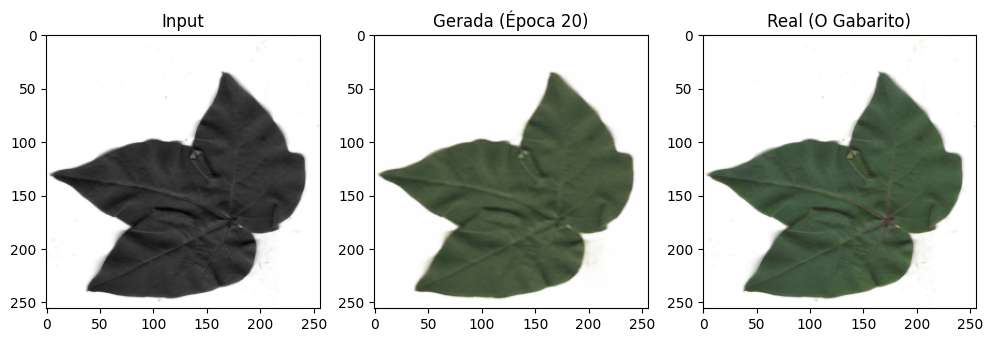

Época [30/100] | Loss D (PatchGAN): 0.0202 | Loss G (UNet): 0.0838 | Tempo: 182s


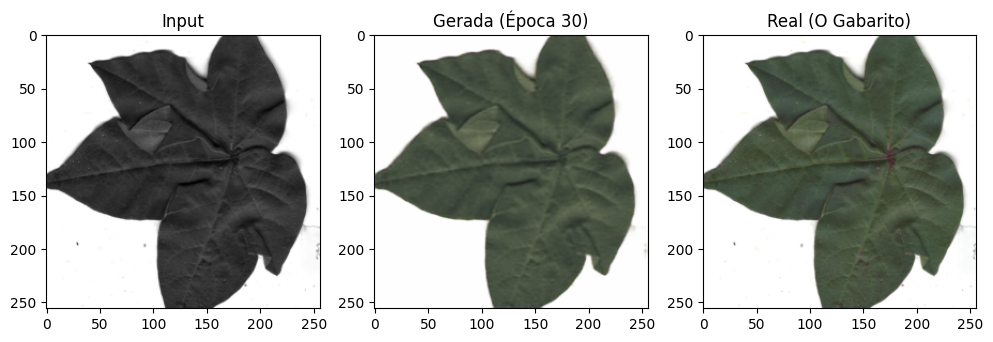

Época [40/100] | Loss D (PatchGAN): 0.0114 | Loss G (UNet): 0.0723 | Tempo: 241s


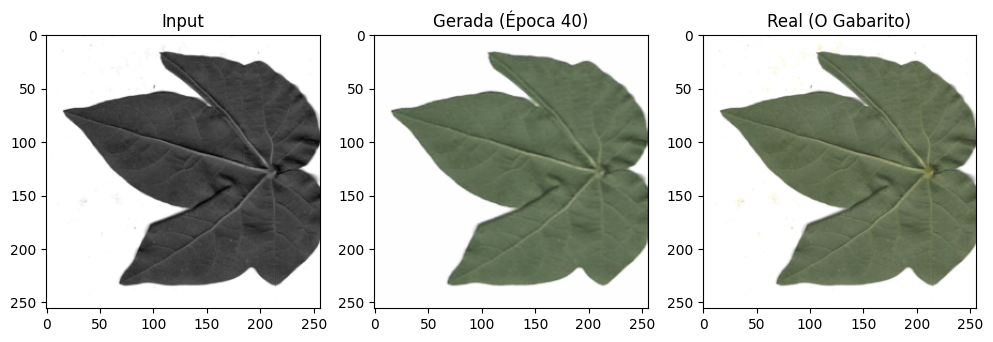

Época [50/100] | Loss D (PatchGAN): 0.0130 | Loss G (UNet): 0.0538 | Tempo: 301s


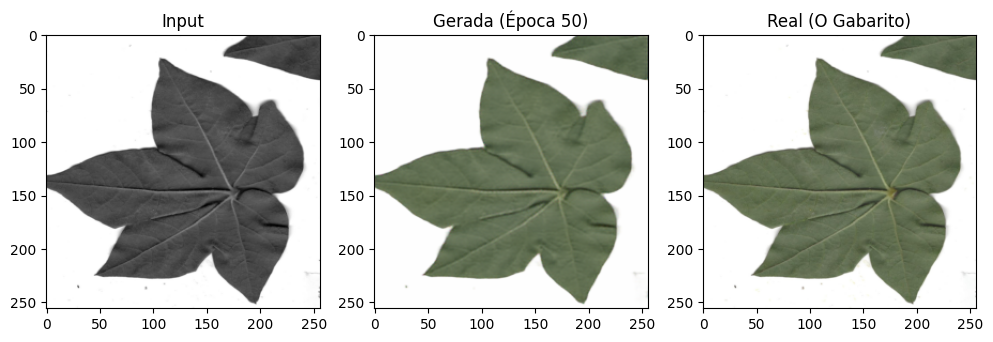

Época [60/100] | Loss D (PatchGAN): 0.1951 | Loss G (UNet): 0.0416 | Tempo: 360s


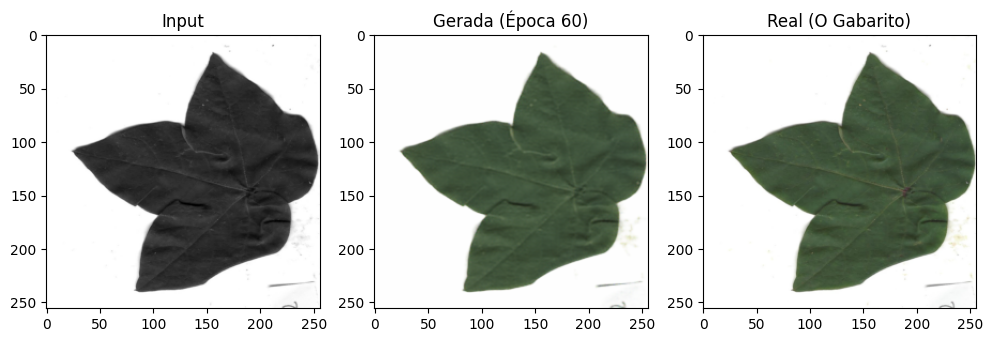

Época [70/100] | Loss D (PatchGAN): 0.0101 | Loss G (UNet): 0.0385 | Tempo: 420s


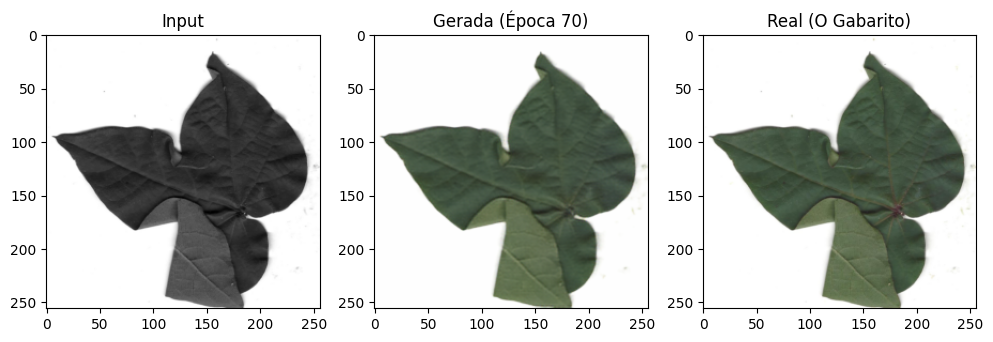

Época [80/100] | Loss D (PatchGAN): 0.0051 | Loss G (UNet): 0.0464 | Tempo: 481s


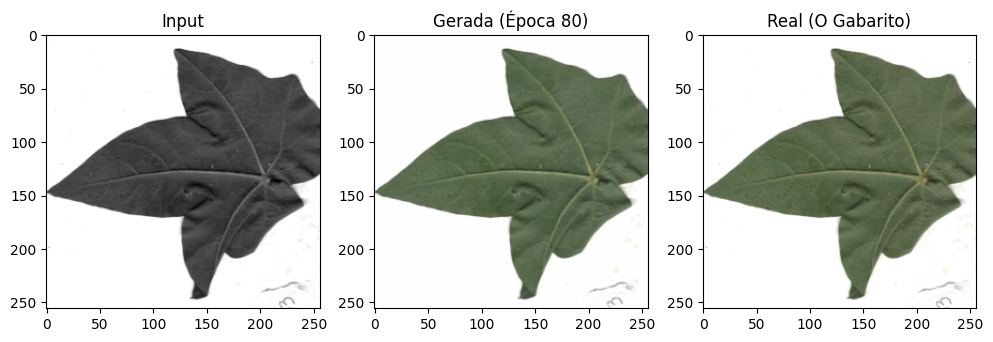

Época [90/100] | Loss D (PatchGAN): 0.0055 | Loss G (UNet): 0.0527 | Tempo: 539s


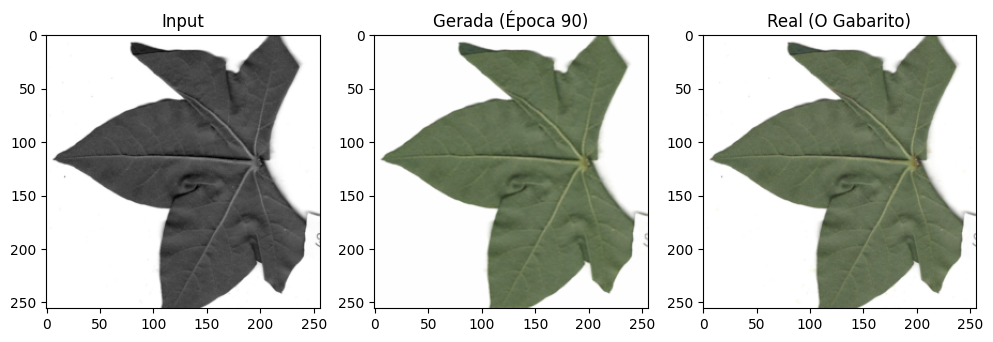

Época [100/100] | Loss D (PatchGAN): 0.0052 | Loss G (UNet): 0.0396 | Tempo: 596s


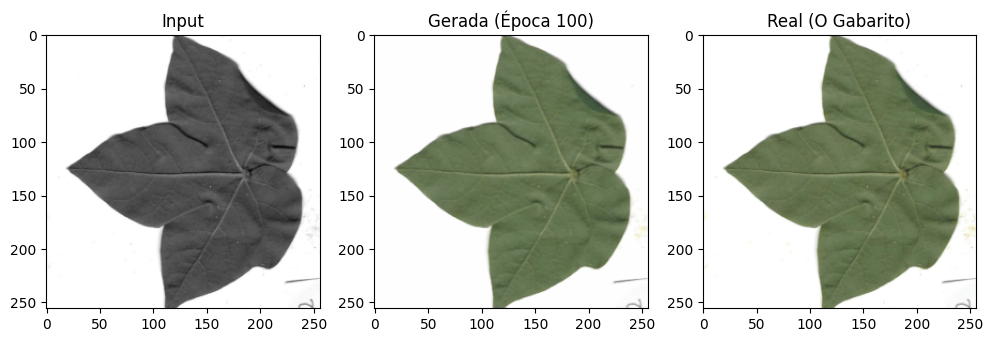

Treinamento Concluído com Sucesso!


In [15]:
import time
import torch.optim as optim
import matplotlib.pyplot as plt

LR = 0.00015
BETA1 = 0.5
BETA2 = 0.999
LAMBDA_PIXEL = 10
NUM_EPOCHS = 100

generator = UNetGenerator().to(device)
discriminator = PatchGAN().to(device)

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_pixel = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

print(f"Iniciando treinamento na placa: {torch.cuda.get_device_name(0)}")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    for i, (gray, real_color) in enumerate(dataloader):

        gray = gray.to(device)
        real_color = real_color.to(device)

        optimizer_G.zero_grad()
        fake_color = generator(gray)
        pred_fake = discriminator(gray, fake_color)

        valid = torch.ones_like(pred_fake).to(device)
        loss_GAN = criterion_pixel(fake_color, real_color)
        loss_pixel = criterion_pixel(fake_color, real_color)

        loss_G = loss_GAN + (LAMBDA_PIXEL * loss_pixel)

        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        pred_real = discriminator(gray, real_color)
        valid = torch.ones_like(pred_real).to(device)
        loss_real = criterion_GAN(pred_real, valid)

        pred_fake = discriminator(gray, fake_color.detach())
        fake_label = torch.zeros_like(pred_fake).to(device)
        loss_fake = criterion_GAN(pred_fake, fake_label)

        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        
    if (epoch + 1) % 10 == 0:
        elapsed = time.time() - start_time
        print(f"Época [{epoch+1}/{NUM_EPOCHS}] | "
              f"Loss D (PatchGAN): {loss_D.item():.4f} | "
              f"Loss G (UNet): {loss_G.item():.4f} | "
              f"Tempo: {elapsed:.0f}s")
        
        with torch.no_grad():
            show_gray = gray[0].cpu().squeeze()
            show_fake = fake_color[0].cpu().permute(1, 2, 0).clip(0, 1)
            show_real = real_color[0].cpu().permute(1, 2, 0)  

            fig, ax = plt.subplots(1, 3, figsize=(12, 4))
            ax[0].imshow(show_gray, cmap='gray'); ax[0].set_title("Input")
            ax[1].imshow(show_fake); ax[1].set_title(f"Gerada (Época {epoch+1})")
            ax[2].imshow(show_real); ax[2].set_title("Real (O Gabarito)")
            plt.show()

print("Treinamento Concluído com Sucesso!")

Criar uma pasta para salvar o modelo da rede e seus pesos

Definição de métricas para a detecção de anomalias

In [19]:
if not os.path.exists('weights'):
    os.makedirs('weights')

print("Salvando os modelos")

torch.save(generator.state_dict(), 'weights/pix2pix_generator.pth')
torch.save(discriminator.state_dict(), 'weights/pix2pix_discriminator.pth')


generator.eval()
example_input = torch.rand(1, 1, 256, 256).to(device)


traced_script_module = torch.jit.trace(generator, example_input, check_trace=False)
traced_script_module.save("weights/pix2pix_netG_ts.pt")

print("Modelos salvos!")
print("   - weights/pix2pix_generator.pth (Para treino)")
print("   - weights/pix2pix_netG_ts.pt    (Para o App)")

Salvando os modelos
Modelos salvos!
   - weights/pix2pix_generator.pth (Para treino)
   - weights/pix2pix_netG_ts.pt    (Para o App)


Modelo carregado.


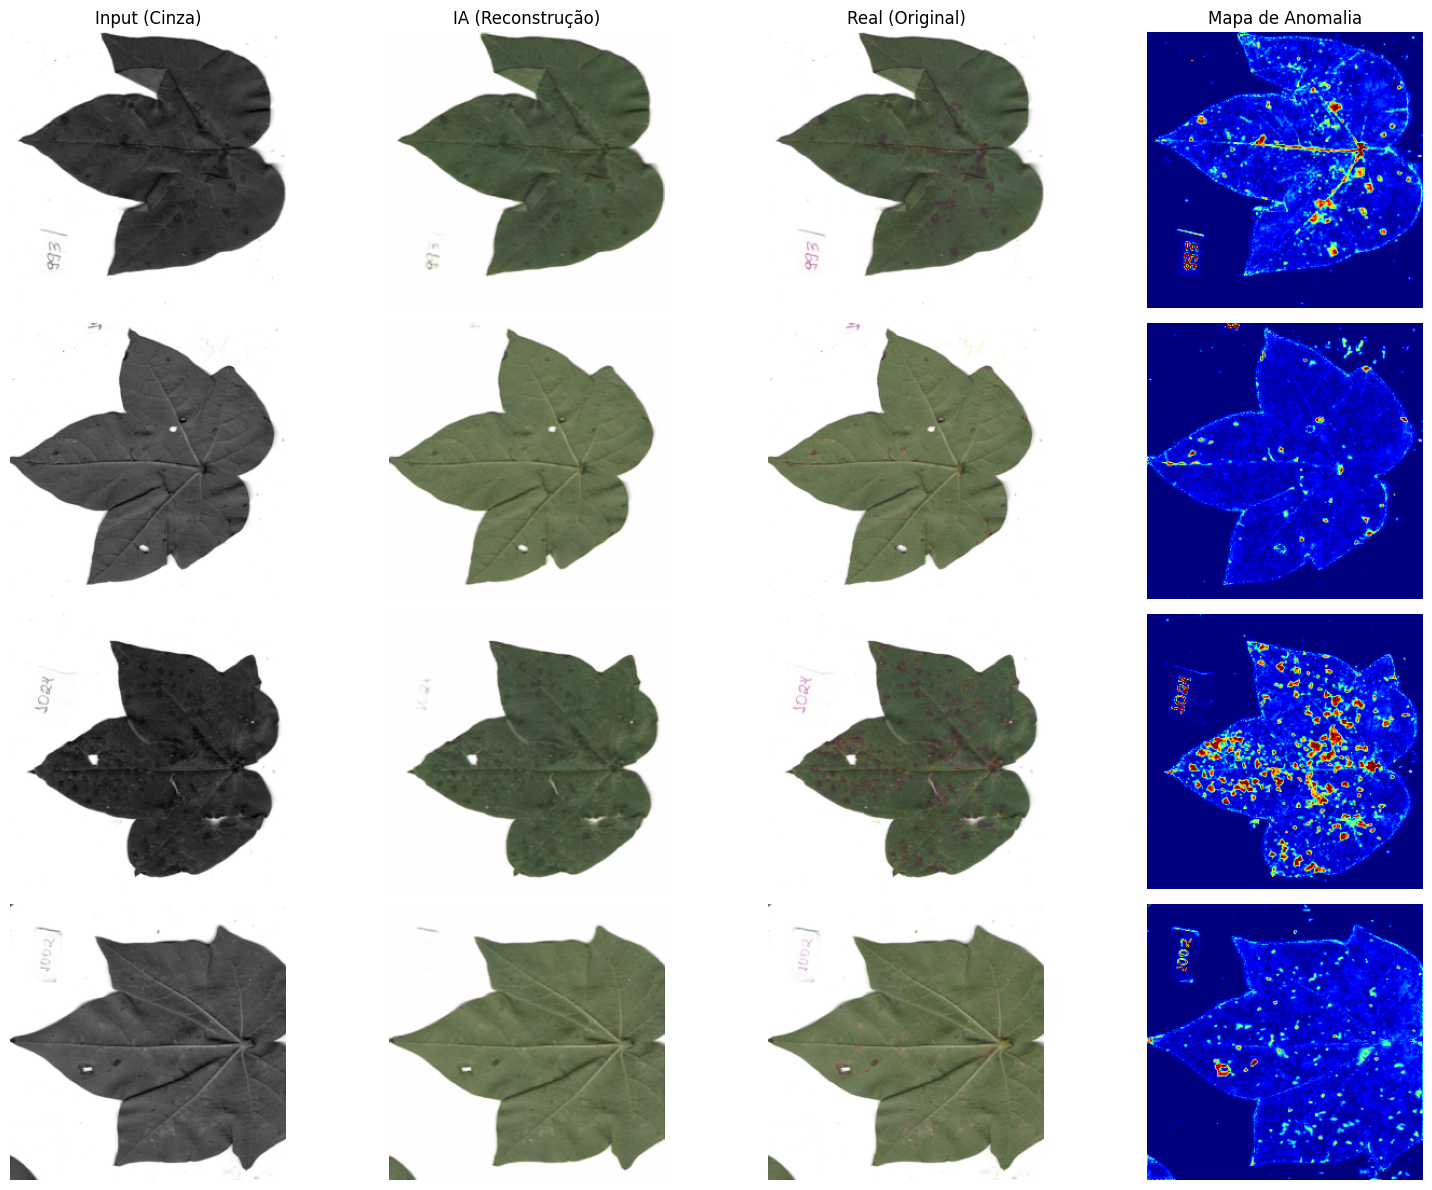

In [20]:
from skimage.color import rgb2lab, deltaE_ciede2000

pasta_teste = './dataset_teste' 
dataset_final = PlantDataset(pasta_teste)
dataloader_final = DataLoader(dataset_final, batch_size=4, shuffle=True)

generator = UNetGenerator().to(device)
try:
    generator.load_state_dict(torch.load('weights/pix2pix_generator.pth', map_location=device))
    print("Modelo carregado.")
except:
    print("Usando modelo da memória (sem carregar do disco).")


generator.train()

gray_batch, real_batch = next(iter(dataloader_final))
gray_batch = gray_batch.to(device)


with torch.no_grad():
    fake_batch = generator(gray_batch)

plt.figure(figsize=(16, 12))

for i in range(min(4, gray_batch.size(0))):
    
    img_cinza = gray_batch[i].cpu().squeeze().numpy()
    
    img_ia = fake_batch[i].cpu().permute(1, 2, 0).numpy()
    img_ia = np.clip(img_ia, 0, 1)
    
    img_real = real_batch[i].cpu().permute(1, 2, 0).numpy()
    img_real = np.clip(img_real, 0, 1)
    
   
    lab_real = rgb2lab(img_real)
    lab_ia = rgb2lab(img_ia)
    mapa_calor = deltaE_ciede2000(lab_real, lab_ia)
    
    plt.subplot(4, 4, i*4 + 1)
    plt.imshow(img_cinza, cmap='gray')
    if i == 0: plt.title("Input (Cinza)")
    plt.axis('off')

    plt.subplot(4, 4, i*4 + 2)
    plt.imshow(img_ia)
    if i == 0: plt.title("IA (Reconstrução)")
    plt.axis('off')

    plt.subplot(4, 4, i*4 + 3)
    plt.imshow(img_real)
    if i == 0: plt.title("Real (Original)")
    plt.axis('off')

    plt.subplot(4, 4, i*4 + 4)
    plt.imshow(mapa_calor, cmap='jet', vmin=0, vmax=20)
    if i == 0: plt.title("Mapa de Anomalia")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
from tqdm import tqdm

print("Calculando métricas em todo o dataset de teste")

ds_healthy = PlantDataset('./dataset_treino') 
dl_healthy = DataLoader(ds_healthy, batch_size=1, shuffle=False)

ds_diseased = PlantDataset('./dataset_teste')
dl_diseased = DataLoader(ds_diseased, batch_size=1, shuffle=False)

def get_scores(dataloader):
    scores = []
    generator.eval()
    with torch.no_grad():
        for gray, real in dataloader: 
            gray = gray.to(device)
            fake = generator(gray)
            
            fake_np = (fake[0].cpu().permute(1, 2, 0).numpy() + 1.0) / 2.0
            real_np = real[0].cpu().permute(1, 2, 0).numpy()
            
            diff = deltaE_ciede2000(rgb2lab(real_np), rgb2lab(np.clip(fake_np, 0, 1)))
            scores.append(np.sum(diff))
    return scores

scores_h = get_scores(dl_healthy)
scores_d = get_scores(dl_diseased)

y_true = [0]*len(scores_h) + [1]*len(scores_d)
y_scores = scores_h + scores_d                 

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_scores > optimal_threshold).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
acc = accuracy_score(y_true, y_pred)

print("\n" + "="*40)
print("="*40)
print(f"AUC:        {roc_auc:.4f}")
print(f"Acurácia:   {acc:.4f}")
print(f"F1-Score:   {f1:.4f}")
print(f"Precision:  {prec:.4f}")
print(f"Recall:     {rec:.4f}")
print("="*40)


Calculando métricas em todo o dataset de teste

AUC:        0.5922
Acurácia:   0.5533
F1-Score:   0.5890
Precision:  0.7619
Recall:     0.4800


In [23]:
print("Cálculo de métricas atualizadas")

ds_healthy = PlantDataset('./dataset_treino') 
dl_healthy = DataLoader(ds_healthy, batch_size=1, shuffle=False)

ds_diseased = PlantDataset('./dataset_teste')
dl_diseased = DataLoader(ds_diseased, batch_size=1, shuffle=False)

# --- FUNÇÃO DE SCORE CORRIGIDA ---
def get_scores_final(dataloader, generator, device):
    scores = []
    generator.eval()
    with torch.no_grad():
        for gray, real in tqdm(dataloader, desc="Processando"):
            gray = gray.to(device)
            
            fake = generator(gray)
            
            fake_np = fake[0].cpu().permute(1, 2, 0).numpy()
            fake_np = np.clip(fake_np, 0, 1) 
            
            real_np = real[0].cpu().permute(1, 2, 0).numpy()
            
            lab_real = rgb2lab(real_np)
            lab_fake = rgb2lab(fake_np)
            diff = deltaE_ciede2000(lab_real, lab_fake)
            
            scores.append(np.sum(diff))
    return scores

print("Calculando scores para SAUDÁVEIS")
scores_h = get_scores_final(dl_healthy, generator, device)

print("Calculando scores para DOENTES")
scores_d = get_scores_final(dl_diseased, generator, device)

y_true = [0] * len(scores_h) + [1] * len(scores_d) 

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_scores > optimal_threshold).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
acc = accuracy_score(y_true, y_pred)

print("\n" + "="*50)
print("✅ RESULTADOS FINAIS PARA O RELATÓRIO:")
print("="*50)
print(f"AUC (Area Under Curve):  {roc_auc:.4f}")
print(f"Acurácia:                {acc:.4f}")
print(f"F1-Score:                {f1:.4f}")
print(f"Precision:               {prec:.4f}")
print(f"Recall:                  {rec:.4f}")
print("="*50)

Cálculo de métricas atualizadas
Calculando scores para SAUDÁVEIS...


Processando: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.32it/s]


Calculando scores para DOENTES...


Processando: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


✅ RESULTADOS FINAIS PARA O RELATÓRIO:
AUC (Area Under Curve):  0.9650  (Ideal: > 0.90)
Acurácia:                0.9000
F1-Score:                0.9223
Precision:               0.9570
Recall:                  0.8900
